# SED evaluation

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from scipy import constants
import pylab as pl
import numpy as np
from matplotlib import rcParams, cm
rcParams['figure.figsize'] = 12, 8

# Imports needed for component separation
from fgbuster import CMB, Dust, Synchrotron, AnalyticComponent, MixingMatrix

## `AnalyticComponenet`
The `component_model` module collects classes for SED evaluation. It has mainly two classes:

* `Component`, abstract class which defines the shared API

    - Evaluation of the SED as well as its first and second order derivatives with respect to the free parameters
    - Keep track of the free parameters
    
* `AnalyticComponent`
    
    - Construct a `Component` from an analytic expression

We'll now focus on the latter. 
An `AnalyticComponent` can be constructed from anything that can be parsed by `sympy`, which include all the most common mathematical functions. A variable called `nu` has to be used to expresses the frequency dependence.

### Construction
As an example, consider the SED of a modified back body

In [3]:
analytic_expr = ('(nu / nu0)**(1 + beta_d) *'
                 '(exp(nu0 / temp * h_over_k) -1)'
                 '/ (exp(nu / temp * h_over_k) - 1)'
                 )

In [4]:
comp = AnalyticComponent(analytic_expr)

The free parameters are automatically detected

In [5]:
comp.params

['beta_d', 'h_over_k', 'nu0', 'temp']

As in this case, some of them are not really free but we did not want to clutter the expression by hardcoding the value. Their value can be specified at construction time.

In [6]:
h_over_k_val = constants.h * 1e9 / constants.k  # Assumes frequencies in GHz
nu0_val = 353.

comp = AnalyticComponent(analytic_expr,  # Same as before
                         h_over_k=h_over_k_val, nu0=nu0_val)  # but now keyword arguments fix some variables

and they are no longer free parameters

In [7]:
comp.params

['beta_d', 'temp']

### Evaluation
Efficient evaluators of the analytic expression are created at construction time. The expression can be evaluated both for a single value and for an array of values. (Note that the free parameters are passed in the same order they appear in `comp.params`)

In [8]:
nu_scalar = 50
beta_scalar = 1.6
temp_scalar = 16.

comp.eval(nu_scalar, beta_scalar, temp_scalar)

0.07227073743860096

In [9]:
nu_vector = np.logspace(1, 3, 20)

sed = comp.eval(nu_vector, beta_scalar, temp_scalar)

print('Output shape is :', sed.shape)

Output shape is : (20,)


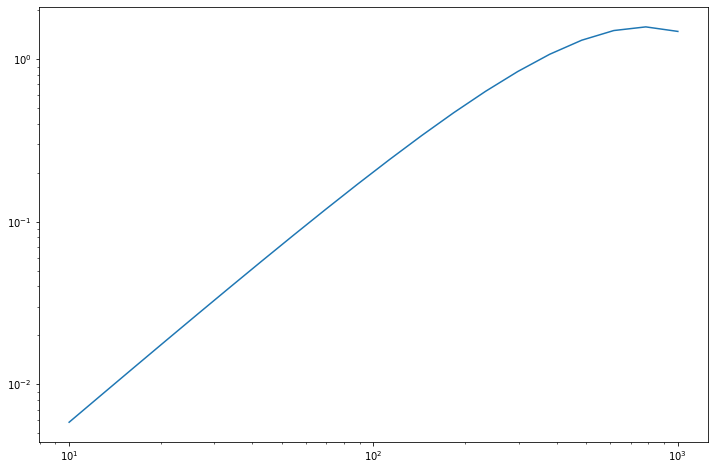

In [10]:
_ = pl.loglog(nu_vector, sed)

Also the free parameters can be arrays

In [11]:
beta_vector = np.linspace(1.2, 2.2, 4)
temp_vector = np.linspace(15, 27, 4)

seds = comp.eval(nu_vector, beta_vector, temp_vector)

print('Output shape is :', seds.shape)

Output shape is : (4, 20)


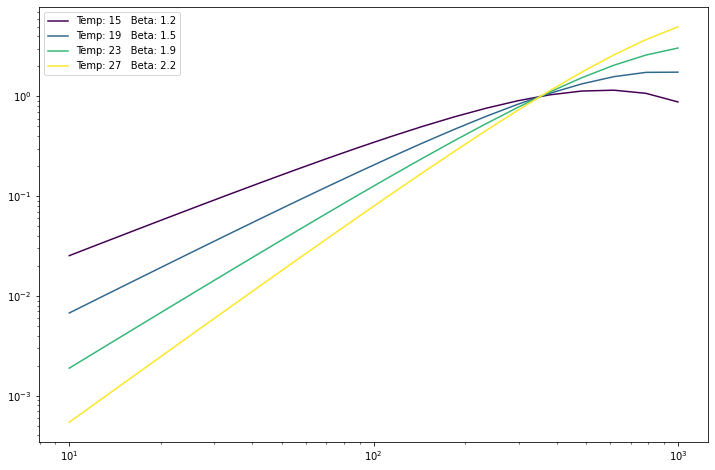

In [12]:
colors_map = cm.ScalarMappable()
colors_map.set_array(beta_vector)
colors_map.autoscale()
colors = lambda x: colors_map.to_rgba(x)
for sed, beta, temp in zip(seds, beta_vector, temp_vector):
    pl.loglog(nu_vector, sed, c=colors(beta), label='Temp: %.0f   Beta: %.1f' % (temp, beta))
_ = pl.legend()

They can be anything that is bradcating-compatible

In [13]:
sedss = comp.eval(nu_vector, beta_vector, temp_vector[:, np.newaxis])

print('Output shape is :', sedss.shape)

Output shape is : (4, 4, 20)


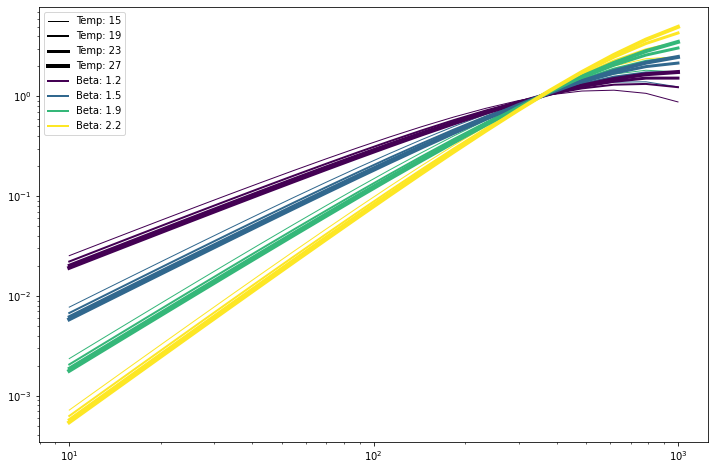

In [14]:
linewidths = lambda x: (x - temp_vector.min()) / 4. + 1

# Legend kludge
for temp in temp_vector:
    pl.plot([353.]*2, [1, 1.001], c='k', lw=linewidths(temp),
              label='Temp: %.0f' % temp)
for beta in beta_vector:
    pl.plot([353.]*2, [1, 1.001], c=colors(beta), lw=2,
              label='Beta: %.1f' % beta)
# Plotting
for temp, seds in zip(temp_vector, sedss):
    for beta, sed in zip(beta_vector, seds):
        pl.loglog(nu_vector, sed,
                  c=colors(beta), lw=linewidths(temp))

_ = pl.legend()

Evaluation is reasonably quick. For example, evaluating a pixel-dependent SED over 5 frequency bands at `nside=1024` takes few seconds.

In [15]:
comp.eval(nu_vector[::4], np.linspace(1., 2., 12*1024**2), 20.).shape

(12582912, 5)

### Derivatives
Another important feature of the `AnalyticComponent`s is that the derivatives with respect to the parameters are computed analytically at construction time and evaluate with respect to all the parameters using

In [16]:
diffs = comp.diff(nu_vector, 1.6, 20.)

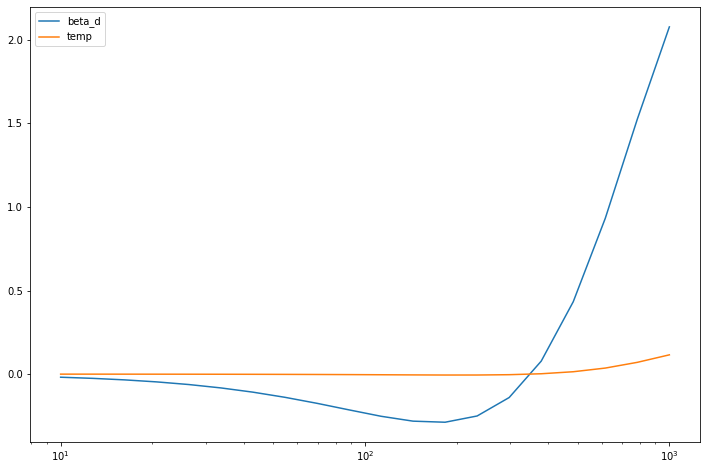

In [17]:
for diff, param in zip(diffs, comp.params):
    pl.semilogx(nu_vector, diff, label=param)
_ = pl.legend()

### Predefined Components
Popular analytic SEDs are ready to be used. For example, we construct the very same `Component` we have been using above with

In [18]:
dust = Dust(353., units='K_RJ')
print(dust.params)

['beta_d', 'temp']


In [19]:
np.allclose(comp.eval(nu_vector, beta_vector, temp_vector), 
            dust.eval(nu_vector, beta_vector, temp_vector)
           )

True

As for the components, parameters can be fixed at construction time

In [20]:
dust_fixed_temp = Dust(353., temp=temp_scalar, units='K_RJ')
print(dust_fixed_temp.params)

['beta_d']


In [21]:
np.allclose(comp.eval(nu_vector, beta_vector, temp_scalar), 
            dust_fixed_temp.eval(nu_vector, beta_vector)
           )

True

## Mixing Matrix
The mixing matrix allows to collect components and evaluate them

In [22]:
mixing_matrix = MixingMatrix(Dust(353.), CMB(), Synchrotron(70.))

In [23]:
mixing_matrix.params

['Dust.beta_d', 'Dust.temp', 'Synchrotron.beta_pl']

In [24]:
mixing_matrix.components

['Dust', 'CMB', 'Synchrotron']

As the `Component`s, the SED and its derivative can be easily evaluated

In [25]:
mm_val = mixing_matrix.eval(nu_vector, 1.6, 20., -3)

print('Output shape is :', mm_val.shape)

Output shape is : (20, 3)


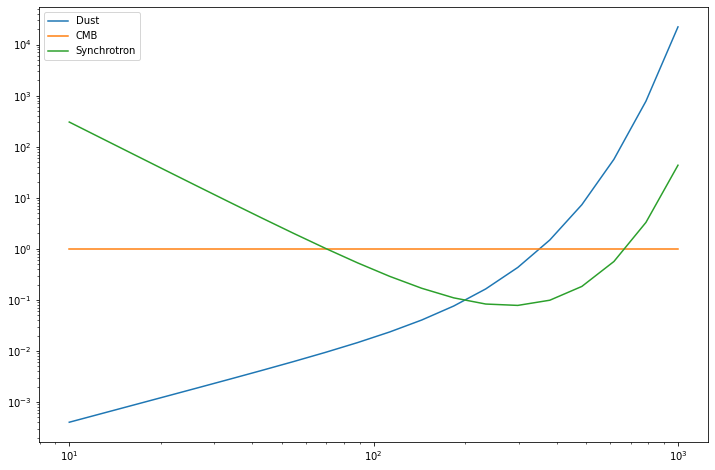

In [26]:
for sed, name in zip(mm_val.T, mixing_matrix.components):
    pl.loglog(nu_vector, sed, label=name)
_ = pl.legend()

In [27]:
mm_diffs = mixing_matrix.diff(nu_vector, 1.6, 20., -1)

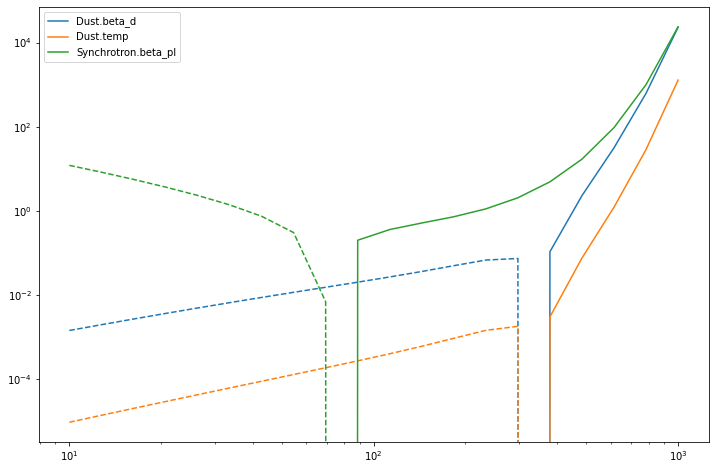

In [28]:
for mm_diff, param in zip(mm_diffs, mixing_matrix.params):
    plot = pl.loglog(nu_vector, mm_diff, label=param)
    pl.loglog(nu_vector, -mm_diff, ls='--', c=plot[-1].get_color())
_ = pl.legend()

Note that only the column affected by the derivative is reported in the output.

In [29]:
mm_diffs[0].shape

(20, 1)

For each parameter, the index of the column affected can be retrieved from the `comp_of_dB` attribute.

In [30]:
mixing_matrix.comp_of_dB

[0, 0, 2]